In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import json
from pprint import pprint
import re

# Define some utils

In [32]:
def is_conservative(s):
    # Define the pattern for "(union|intersection|setminus) X.[RL] X.[RL]"
    pattern_main = r'(union|intersection|setminus) (X\.R X\.L|X\.L X\.R)'
    
    # Find all occurrences of this pattern
    main_matches = re.findall(pattern_main, s)
    
    # Remove the matched main pattern from the string to check for the presence of X.R or X.L exclusively
    s_without_main = re.sub(pattern_main, '', s)
    
    # Check for exclusive presence of X.R or X.L in the rest of the string
    x_r_matches = re.findall(r'X\.R', s_without_main)
    x_l_matches = re.findall(r'X\.L', s_without_main)
    
    # Both X.R and X.L should not be present together
    # This returns False if either both are present or both are absent
    if bool(x_r_matches) and bool(x_l_matches):  
        return False
    
    # If all conditions are met, the string is conservative
    return len(main_matches)>0 

In [89]:
def parse_sexpr(s):
    """Parse a string s into a nested list representation of s-expressions."""
    def tokenize(s):
        """Break the input string into tokens."""
        s = s.replace('(', ' ( ').replace(')', ' ) ')  # Add spaces around parentheses
        return s.split()

    def read_from_tokens(tokens):
        """Recursively read an expression from the token list."""
        if not tokens:
            raise SyntaxError("Unexpected EOF while reading.")
        
        token = tokens.pop(0)

        if token == '(':
            # Start a new list
            result = []
            while tokens[0] != ')':
                result.append(read_from_tokens(tokens))
            tokens.pop(0)  # Pop the ')'
            return result
        elif token == ')':
            raise SyntaxError("Unexpected )")
        else:
            # Atom (either symbol, number, or string)
            return atom(token)

    def atom(token):
        """Convert a token into an appropriate Python type (e.g., number or string)."""
        try:
            return int(token)  # Try converting to integer
        except ValueError:
            try:
                return float(token)  # Try converting to float
            except ValueError:
                return token  # Treat as symbol (string)

    # Tokenize the input string and parse it into a nested list
    tokens = tokenize(s)
    return read_from_tokens(tokens)

In [33]:
# Example usage
test_string = "This is an intersection X.R X.L example with X.R only X.L."
print(is_conservative(test_string))

False


# Tradeoff analysis

In [3]:
import ijson

In [14]:
import re
from collections import Counter

In [56]:
datapath = "../../data/testrun/likweight_30.000000_nobs_100.json"

In [57]:
data = []
with open(datapath, 'r') as openfile:
    parser = ijson.parse(openfile)
    counts = Counter({"1":0, "2":0, "3":0})
    hdata = dict()
    for i, (prefix, event, value) in enumerate(parser):
        # print(prefix, event, value)
        # increment count of quantifier
        # start of sample
        if (prefix == "topN.item") and (event=='start_map'):
            hdata = dict()
            counts = Counter({"1":0, "2":0, "3":0})
        elif prefix == "topN.item.data.item.output":
            used = re.findall(r'(?<=Q)\d', value) 
            counts.update(used)
        elif prefix == "topN.item.hypothesis":
            hdata['hypothesis'] = value
        elif prefix == "topN.item.likelihood":
            hdata['likelihood'] = value
        elif prefix == "topN.item.posterior":
            hdata['posterior'] = value
        elif prefix == "topN.item.prior":
            hdata['prior'] = value
        # end of sample
        elif (prefix == "topN.item") and (event=='end_map'):
            hdata['counts'] = counts
            data.append(hdata)
            pprint(hdata)

{'counts': Counter({'3': 79, '2': 18, '1': 0}),
 'hypothesis': 'λx.( intEq ( cardinality ( union X.R X.L ) X.c ) ( cardinality '
               'X.R X.c ) ) | ( intGt ( cardinality X.R X.c ) ( cardinality '
               'X.R X.c ) ) | ( intEq 0 ( cardinality X.L X.c ) ) | ( intEq 0 '
               '( cardinality X.L X.c ) )',
 'likelihood': Decimal('-53.441647621171825'),
 'posterior': Decimal('-76.33371992909957'),
 'prior': Decimal('-22.892072307927744')}
{'counts': Counter({'3': 79, '2': 18, '1': 0}),
 'hypothesis': 'λx.( intEq ( cardinality ( union X.R X.L ) X.c ) ( cardinality '
               'X.R X.c ) ) | ( intEq 0 ( cardinality X.L X.c ) ) | ( intGt ( '
               'cardinality X.L X.c ) ( cardinality X.L X.c ) ) | ( intGt ( '
               'cardinality X.R X.c ) 1 )',
 'likelihood': Decimal('-53.44164762117182'),
 'posterior': Decimal('-76.33371992909956'),
 'prior': Decimal('-22.892072307927744')}
{'counts': Counter({'3': 79, '2': 18, '1': 0}),
 'hypothesis': 'λx.( in

In [58]:
len(data)

100

In [61]:
df_counts = pd.DataFrame(data)

In [63]:
data

[{'hypothesis': 'λx.( intEq ( cardinality ( union X.R X.L ) X.c ) ( cardinality X.R X.c ) ) | ( intGt ( cardinality X.R X.c ) ( cardinality X.R X.c ) ) | ( intEq 0 ( cardinality X.L X.c ) ) | ( intEq 0 ( cardinality X.L X.c ) )',
  'likelihood': Decimal('-53.441647621171825'),
  'posterior': Decimal('-76.33371992909957'),
  'prior': Decimal('-22.892072307927744'),
  'counts': Counter({'3': 79, '2': 18, '1': 0})},
 {'hypothesis': 'λx.( intEq ( cardinality ( union X.R X.L ) X.c ) ( cardinality X.R X.c ) ) | ( intEq 0 ( cardinality X.L X.c ) ) | ( intGt ( cardinality X.L X.c ) ( cardinality X.L X.c ) ) | ( intGt ( cardinality X.R X.c ) 1 )',
  'likelihood': Decimal('-53.44164762117182'),
  'posterior': Decimal('-76.33371992909956'),
  'prior': Decimal('-22.892072307927744'),
  'counts': Counter({'3': 79, '2': 18, '1': 0})},
 {'hypothesis': 'λx.( intEq ( cardinality X.R X.c ) ( cardinality ( union X.L X.R ) X.c ) ) | ( intGt ( cardinality X.L X.c ) 0 ) | ( intGt ( cardinality X.R X.c ) 1 )

In [62]:
df_counts.iloc[-20:]

,hypothesis,likelihood,posterior,prior,counts
80,λx.( ( X.Q X.L ) ( union X.L X.R ) ) | ( intGt...,-54.69977416773166,-72.98321008169484,-18.28343591396317,"{'1': 0, '2': 18, '3': 79}"
81,λx.( ( X.Q X.R ) ( intersection X.R X.L ) ) | ...,-45.89956745485213,-72.8778351691211,-26.97826771426897,"{'1': 0, '2': 18, '3': 79}"
82,λx.( ( X.Q X.R ) ( union X.L X.R ) ) | ( intEq...,-54.3103208353033,-72.59375674926648,-18.28343591396317,"{'1': 0, '2': 18, '3': 79}"
83,λx.( ( X.Q X.L ) ( union X.R X.L ) ) | ( intEq...,-49.90659700031611,-72.58448206895171,-22.677885068635604,"{'1': 0, '2': 18, '3': 79}"
84,λx.( ( X.Q X.L ) ( union X.L X.R ) ) | ( intEq...,-52.8193768454305,-72.57075110955407,-19.751374264123566,"{'1': 0, '2': 18, '3': 79}"
85,λx.( ( X.Q X.L ) ( union X.L X.R ) ) | ( intGt...,-53.441647621171825,-72.45905271021519,-19.01740508904337,"{'1': 0, '2': 18, '3': 79}"
86,λx.( ( X.Q X.L ) ( union X.R X.L ) ) | ( intGt...,-49.698652846148114,-72.37653791478371,-22.677885068635604,"{'1': 0, '2': 18, '3': 79}"
87,λx.( ( X.Q X.L ) ( union X.L X.R ) ) | ( intGt...,-52.60987100449991,-72.36124526862348,-19.75137426412357,"{'1': 0, '2': 18, '3': 79}"
88,λx.( and ( intGt ( cardinality X.L X.c ) ( car...,-39.59167913716216,-72.2566148263638,-32.66493568920164,"{'1': 0, '2': 18, '3': 79}"
89,λx.( ( X.Q X.L ) ( intersection X.R X.L ) ) | ...,-53.848635994718464,-72.13207190868164,-18.28343591396317,"{'1': 0, '2': 18, '3': 79}"


In [10]:
data.keys()

dict_keys(['topN', 'topNSerialized'])

In [15]:
re.findall(r'(?<=Q)\d', '( Q1 target negative) ') 

['1']

In [276]:
data['topN'][2]['data']

[{'input': [[-6, True], [-3, True], [3, True], [6, True], [8, True]],
  'output': '( ( Q1 5 ) distractor )'},
 {'input': [[-5, True], [-2, True], [0, True], [3, True], [6, True]],
  'output': '( ( Q1 1 ) distractor )'},
 {'input': [[-4, False], [-2, True], [0, True], [2, True], [10, True]],
  'output': '( ( Q1 negative ) distractor )'},
 {'input': [[-10, False], [-1, True], [0, True], [2, False], [9, True]],
  'output': '( ( Q3 even ) distractor )'},
 {'input': [[-6, True], [-2, True], [2, True], [5, False], [9, True]],
  'output': '( ( Q1 5 ) distractor )'},
 {'input': [[-9, True], [0, False], [5, True], [6, False], [10, False]],
  'output': '( ( Q3 distractor ) even )'},
 {'input': [[-10, False], [-7, True], [-3, True], [1, True], [2, True]],
  'output': '( ( Q3 even ) distractor )'},
 {'input': [[-10, False], [-3, True], [-2, True], [-1, True], [0, True]],
  'output': '( ( Q1 even ) distractor )'},
 {'input': [[-9, False], [-3, True], [-2, True], [5, False], [10, True]],
  'output':

In [264]:
def extract_counts(commdata):
    used_quants = [
        re.findall(r'(?<=Q)\d', x['output']) 
        for x in commdata['data']
    ]
    flattened = [
        int(x)
        for sublist in used_quants
        for x in sublist
    ]
    counts = dict(Counter(flattened))
    return counts

In [265]:
counts = list(map(extract_counts, data['topN']))

In [266]:
df_counts = pd.DataFrame(counts)

In [267]:
df_counts

,1,3,2
0,71,66,63
1,71,66,63
2,71,66,63
3,71,66,63
4,71,66,63
...,...,...,...
15053,71,66,63
15054,71,66,63
15055,71,66,63
15056,71,66,63


In [ ]:
data_ = [
    {
        'h': i['hypothesis'], 
        'lik': i['likelihood'], 
        'prior': i['prior'], 
        'post': i['posterior'], 
    }
    for i in data['topN']
]

df = pd.DataFrame(data_)
split_df = pd.DataFrame(df['h'].str.split('|').to_list(), columns=['c', 'q1', 'q2', 'q3'])
df = pd.concat([df, split_df], axis=1)

In [80]:
df

,h,lik,prior,post,cons,c,q1,q2,q3
0,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-97.116527,-66.769296,-163.885823,True,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality ( setminus X.L X....,( not ( intEq ( - 1 ( + 1 0 ) ) ( - ( cardina...
1,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-96.918190,-66.769296,-163.687485,True,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality ( setminus X.L X....,( not ( intEq ( - 1 ( + 1 0 ) ) ( - ( cardina...
2,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-96.474013,-66.769296,-163.243308,True,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality ( setminus X.R X....,( not ( intEq ( - 1 ( + 1 0 ) ) ( - ( cardina...
3,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-99.030866,-63.449742,-162.480609,True,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality X.L X.c ) ( - ( c...,( not ( intEq ( - 1 ( + 1 0 ) ) ( - 1 ( cardi...
4,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-94.675769,-67.503265,-162.179034,True,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq ( cardinality ( intersection X.R X.R ...,( intEq 0 ( - 1 ( - ( cardinality ( union X.R...,( not ( intEq ( - 1 ( + 1 0 ) ) ( - 1 ( cardi...
...,...,...,...,...,...,...,...,...,...
15053,λx.( ( X.Q ( setminus X.R X.L ) ) ( nTh 0 X.c ...,-46.794614,-24.153204,-70.947817,True,λx.( ( X.Q ( setminus X.R X.L ) ) ( nTh 0 X.c ...,( intGt ( cardinality X.L X.c ) ( cardinality...,( intEq 0 ( cardinality X.L X.c ) ),( intEq 0 ( cardinality X.L X.c ) )
15054,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,-43.034449,-27.472757,-70.507206,False,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,( intEq 0 ( cardinality X.R X.c ) ),( intGt ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...
15055,λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) | ...,-51.769194,-18.283436,-70.052630,True,λx.( ( X.Q ( intersection X.L X.R ) ) X.L ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...
15056,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,-40.733838,-28.206726,-68.940564,False,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,( intEq 0 ( cardinality X.R X.c ) ),( intGt 1 ( cardinality X.R X.c ) ),( intEq ( cardinality X.R X.c ) ( cardinality...


In [96]:
from pprint import pprint

In [184]:
def find_dependence(expression):
    if isinstance(expression, list):
        leftarg, *rightargs = expression
    else:
        leftarg = expression
    # list[bool] refers to [U-(L or R), L-R, R-L, L&R]
    # Set of domain subsets on which a composition function
    # allows the quantifiers to depend
    if leftarg == 'X.Q':
        return find_dependence(rightargs)
    elif leftarg == 'X.L':
        return [False, True, False, True]
    elif leftarg == 'X.R':
        return [False, False, True, True]
    elif leftarg == 'X.c':
        return [True, True, True, True]
    elif leftarg in ['union', 'intEq', 'intGt', 'and', 'or', '+', '-']:
        # depends at most on the union of the sets
        # on which the arguments depend
        return list(map(
            lambda x, y: x or y, 
            *[find_dependence(x) for x in rightargs]
        ))
    elif leftarg == 'not':
        return find_dependence(rightargs)
    elif leftarg == 'intersection':
        return list(map(
            lambda x, y: x and y, 
            *[find_dependence(x) for x in rightargs]
        ))
    elif leftarg == 'setminus':
        # U-(L or R), L-R, R-L, L&R
        l, r = rightargs
        return list(map(
            lambda x, y: x and not y, 
            find_dependence(l),
            find_dependence(r)
        ))
    elif leftarg == 'nTh':
        return find_dependence(rightargs[2])
    elif leftarg == 'cardinality':
        return find_dependence(rightargs[0])
    elif leftarg in [0, 1]:
        return [False, False, False, False]
    elif rightargs == []:
        return find_dependence(leftarg)
    elif isinstance(leftarg, list):
        return list(map(
            lambda x, y: x or y, 
            find_dependence(leftarg),
            find_dependence(rightargs)
        ))
    else:
        assert False, f"Could not find {leftarg}"

def is_conservative(dependencies):
    return (
        (dependencies == [False, True, False, True]) or
        (dependencies == [False, False, True, True]) or
        (dependencies == [False, False, False, True])
    )

In [194]:
comps = df['c'].str[3:]

In [195]:
df['cons'] = list(map(lambda x: is_conservative(find_dependence(parse_sexpr(x))), comps.to_list()))

In [217]:
df.sort_values('post')

,h,lik,prior,post,cons,c,q1,q2,q3
0,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-97.116527,-66.769296,-163.885823,False,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality ( setminus X.L X....,( not ( intEq ( - 1 ( + 1 0 ) ) ( - ( cardina...
1,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-96.918190,-66.769296,-163.687485,False,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality ( setminus X.L X....,( not ( intEq ( - 1 ( + 1 0 ) ) ( - ( cardina...
2,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-96.474013,-66.769296,-163.243308,False,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality ( setminus X.R X....,( not ( intEq ( - 1 ( + 1 0 ) ) ( - ( cardina...
3,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-99.030866,-63.449742,-162.480609,False,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq 1 ( - ( cardinality X.L X.c ) 0 ) ),( intEq 0 ( - ( cardinality X.L X.c ) ( - ( c...,( not ( intEq ( - 1 ( + 1 0 ) ) ( - 1 ( cardi...
4,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,-94.675769,-67.503265,-162.179034,False,λx.( intGt ( cardinality ( union X.R X.L ) X.c...,( intEq ( cardinality ( intersection X.R X.R ...,( intEq 0 ( - 1 ( - ( cardinality ( union X.R...,( not ( intEq ( - 1 ( + 1 0 ) ) ( - 1 ( cardi...
...,...,...,...,...,...,...,...,...,...
15053,λx.( ( X.Q ( setminus X.R X.L ) ) ( nTh 0 X.c ...,-46.794614,-24.153204,-70.947817,True,λx.( ( X.Q ( setminus X.R X.L ) ) ( nTh 0 X.c ...,( intGt ( cardinality X.L X.c ) ( cardinality...,( intEq 0 ( cardinality X.L X.c ) ),( intEq 0 ( cardinality X.L X.c ) )
15054,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,-43.034449,-27.472757,-70.507206,False,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,( intEq 0 ( cardinality X.R X.c ) ),( intGt ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...
15055,λx.( ( X.Q ( intersection X.L X.R ) ) X.L ) | ...,-51.769194,-18.283436,-70.052630,True,λx.( ( X.Q ( intersection X.L X.R ) ) X.L ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...,( intGt ( cardinality X.L X.c ) ( cardinality...
15056,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,-40.733838,-28.206726,-68.940564,False,λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) (...,( intEq 0 ( cardinality X.R X.c ) ),( intGt 1 ( cardinality X.R X.c ) ),( intEq ( cardinality X.R X.c ) ( cardinality...


In [206]:
df[df['cons']==False]['c'].unique()

array(['λx.( intGt ( cardinality ( union X.R X.L ) X.c ) 1 ) ',
       'λx.( intEq 0 1 ) ', 'λx.( intGt 0 ( - 0 1 ) ) ',
       'λx.( intGt ( + 1 0 ) 1 ) ', 'λx.( intEq 1 ( - 0 1 ) ) ',
       'λx.( intGt 0 ( + 1 1 ) ) ', 'λx.( intEq 1 0 ) ',
       'λx.( ( X.Q X.L ) X.R ) ',
       'λx.( and ( not ( not ( and ( ( X.Q X.L ) X.L ) ( intEq ( cardinality X.R X.c ) 1 ) ) ) ) ( intGt 1 ( + 1 1 ) ) ) ',
       'λx.( intGt 0 ( + 1 0 ) ) ', 'λx.( intEq 1 1 ) ',
       'λx.( intGt 0 1 ) ', 'λx.( intGt 0 0 ) ',
       'λx.( and ( not ( not ( and ( ( X.Q X.L ) X.L ) ( intEq ( cardinality X.R X.c ) 1 ) ) ) ) ( intGt 1 1 ) ) ',
       'λx.( not ( ( X.Q ( union X.R X.R ) ) X.L ) ) ',
       'λx.( intEq 0 0 ) ', 'λx.( intGt 1 1 ) ',
       'λx.( intEq ( - 1 0 ) 0 ) ', 'λx.( not ( ( X.Q X.L ) X.R ) ) ',
       'λx.( and ( intGt 0 1 ) ( intEq 0 1 ) ) ',
       'λx.( intEq 0 ( + ( - 1 0 ) 0 ) ) ',
       'λx.( ( X.Q ( union X.R ( nTh 0 X.c ( nTh 0 X.c X.L ) ) ) ) X.R ) ',
       'λx.( intEq ( - ( - 0 ( 

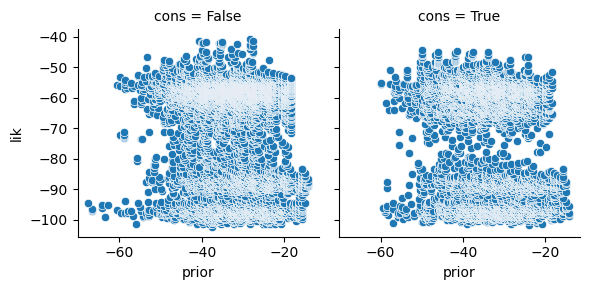

In [211]:
g = sns.FacetGrid(df, col='cons')

g.map_dataframe(
    sns.scatterplot,
    x='prior',
    y='lik',
)

In [221]:
df[df['cons']==False].sort_values('lik').iloc[-10:]['h'].to_list()

['λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) ( intersection X.R X.L ) ) | ( intGt 1 ( cardinality X.R X.c ) ) | ( intEq ( cardinality X.R X.c ) ( cardinality X.L X.c ) ) | ( intGt ( - 0 ( cardinality ( setminus X.L X.L ) X.c ) ) ( cardinality X.L X.c ) )',
 'λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) ( intersection X.R X.L ) ) | ( intGt 1 ( cardinality X.R X.c ) ) | ( intEq ( cardinality X.R X.c ) ( cardinality X.L X.c ) ) | ( intGt ( - ( cardinality X.R X.c ) ( cardinality ( setminus X.L X.L ) X.c ) ) ( cardinality X.L X.c ) )',
 'λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) ( intersection X.R X.L ) ) | ( intEq 0 ( cardinality X.R X.c ) ) | ( intEq ( cardinality X.R X.c ) ( cardinality X.L X.c ) ) | ( intGt ( cardinality ( intersection X.L X.L ) X.c ) ( cardinality ( union ( intersection X.R X.L ) X.R ) X.c ) )',
 'λx.( ( X.Q ( union X.R ( nTh 0 X.c X.L ) ) ) ( intersection X.R X.L ) ) | ( intEq 0 ( cardinality X.R X.c ) ) | ( intEq ( cardinality X.R X.c ) ( cardinality X.L X.c ) 

# Iterated learning (old)

## Utils

In [6]:
def get_data(datadir):
    data = []
    for findex in range(1,100):
        print(findex, end=' ')
        try:
            fpath = datadir+str(findex)
            run = dict()
            with open(fpath+'/parameters.json','r') as openf:
                params = json.load(openf)
                run['params'] = params
            run['generation'] = []
            for genindex in range(200):
                try:
                    with open(f'{fpath}/generation_{genindex}.json') as openf:
                        jsondata = json.load(openf)
                        for string in ['commData', 'learningData', 'topN', 'topNSerialized']:
                            try:
                                del jsondata[string]
                            except:
                                pass
                        run['generation'].append(jsondata)
                except FileNotFoundError:
                    pass
            data.append(run)
        except FileNotFoundError:
            pass
    
    reshuffled_data = []
    for expi, exp in enumerate(data):
        print(expi, sep=' ')
        for geni, gen in enumerate(exp['generation']):
            for childi, child in enumerate(gen['children']):
                original = None
                try:
                    original = child['originalHypothesis']
                except:
                    pass
                reshuffled_data.append({
                    'exp': expi,
                    'gen': geni,
                    'child': childi,
                    'hyp': child['hypothesis'],
                    'commAcc': child['commAcc'],
                    'parent': child['parentIndex'] if geni>0 else None,
                    'original': original
                })
    reshuffled_data = pd.DataFrame(reshuffled_data)
    reshuffled_data[['comp', 'Q1', 'Q2', 'Q3']] = reshuffled_data.hyp.str.split('|',expand=True)
    reshuffled_data['conservative'] = reshuffled_data.comp.apply(is_conservative)
    return reshuffled_data

In [7]:
print(is_conservative('λx.( not ( ( X.Q ( intersection X.L X.R ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( union X.R X.L ) ) X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( setminus X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.L X.R ) ) '))
print(is_conservative('λx.( ( X.Q X.L ) ( union X.R X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.L X.R ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.L X.L ) ) X.L ) ) '))
print(is_conservative('λx.( not ( ( X.Q ( setminus X.R X.R ) ) X.L ) ) '))

True
True
True
True
True
True
False
False


## Communication + learning

### Get data

In [8]:
reshuffled_data = get_data("./../../data/third_test/")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [9]:
reshuffled_data

,exp,gen,child,hyp,commAcc,parent,original,comp,Q1,Q2,Q3,conservative
0,0,0,0,λx.( intEq 0 ( cardinality X.L X.c ) ) | ( int...,-325.695381,NaN,None,λx.( intEq 0 ( cardinality X.L X.c ) ),( intEq ( - ( cardinality X.R X.c ) ( - ( - (...,( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) 0 ),False
1,0,0,1,λx.( intGt ( - 1 1 ) ( cardinality X.L X.c ) )...,-318.953887,NaN,None,λx.( intGt ( - 1 1 ) ( cardinality X.L X.c ) ),( intEq 1 ( cardinality X.R X.c ) ),( intGt ( cardinality X.L X.c ) ( - ( cardina...,( intGt ( cardinality ( union X.L X.L ) X.c )...,False
2,0,0,2,λx.( ( X.Q ( nTh ( - 0 ( - 0 ( cardinality ( u...,-322.404006,NaN,None,λx.( ( X.Q ( nTh ( - 0 ( - 0 ( cardinality ( u...,( intGt ( - ( cardinality X.L X.c ) ( cardina...,( intEq ( + ( cardinality ( setminus X.L X.L ...,( or ( and ( intGt ( cardinality X.L X.c ) 0 ...,False
3,0,0,3,λx.( intGt 0 0 ) | ( intGt ( - 1 ( cardinality...,-322.379545,NaN,None,λx.( intGt 0 0 ),( intGt ( - 1 ( cardinality X.R X.c ) ) ( - (...,( and ( intGt ( - ( cardinality X.L X.c ) 1 )...,( intEq ( cardinality X.L X.c ) ( cardinality...,False
4,0,0,4,λx.( intGt 1 ( cardinality X.R X.c ) ) | ( or ...,-325.834869,NaN,None,λx.( intGt 1 ( cardinality X.R X.c ) ),( or ( intEq ( cardinality X.R X.c ) 0 ) ( or...,( intGt 0 ( cardinality X.L X.c ) ),( intGt ( + ( cardinality X.L X.c ) ( - 1 ( c...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
64635,63,100,5,λx.( ( X.Q X.L ) X.L ) | ( intEq ( cardinality...,-280.537378,0.0,None,λx.( ( X.Q X.L ) X.L ),( intEq ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) 1 ),False
64636,63,100,6,λx.( intEq 1 1 ) | ( intEq ( cardinality X.L X...,-329.061706,0.0,None,λx.( intEq 1 1 ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq 0 ( cardinality X.R X.c ) ),( intEq ( cardinality X.R X.c ) ( cardinality...,False
64637,63,100,7,λx.( ( X.Q X.L ) X.L ) | ( intEq ( cardinality...,-329.255322,0.0,None,λx.( ( X.Q X.L ) X.L ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq 1 1 ),( intGt ( cardinality X.R X.c ) 0 ),False
64638,63,100,8,λx.( ( X.Q X.R ) X.L ) | ( intEq ( cardinality...,-297.787469,0.0,None,λx.( ( X.Q X.R ) X.L ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intGt 1 0 ),( intEq ( cardinality X.R X.c ) 1 ),False


### Plot comm accuracy by conservativity

In [11]:
reshuffled_data.commAcc[reshuffled_data.conservative]

6       -270.396765
13      -291.729841
14      -299.488436
15      -282.694160
16      -291.577433
            ...    
62615   -272.441714
62617   -282.185852
62619   -298.047199
63021   -319.406204
63365   -314.147378
Name: commAcc, Length: 10208, dtype: float64

In [12]:
reshuffled_data.commAcc[np.logical_not(reshuffled_data.conservative)]

0       -325.695381
1       -318.953887
2       -322.404006
3       -322.379545
4       -325.834869
            ...    
64635   -280.537378
64636   -329.061706
64637   -329.255322
64638   -297.787469
64639   -280.937222
Name: commAcc, Length: 54432, dtype: float64

### Plot baseline vs evolved frequency of conservativity 

In [10]:
baseline = reshuffled_data[reshuffled_data.gen==0].conservative.mean()
evolved = reshuffled_data[reshuffled_data.gen<=40].conservative.mean()
print('baseline: ', baseline)
print('evolved:  ', evolved)
print(evolved/baseline)

baseline:  0.05
evolved:   0.1666158536585366
3.332317073170732


### Plot evolution of conservativity

0
14
28
42
56


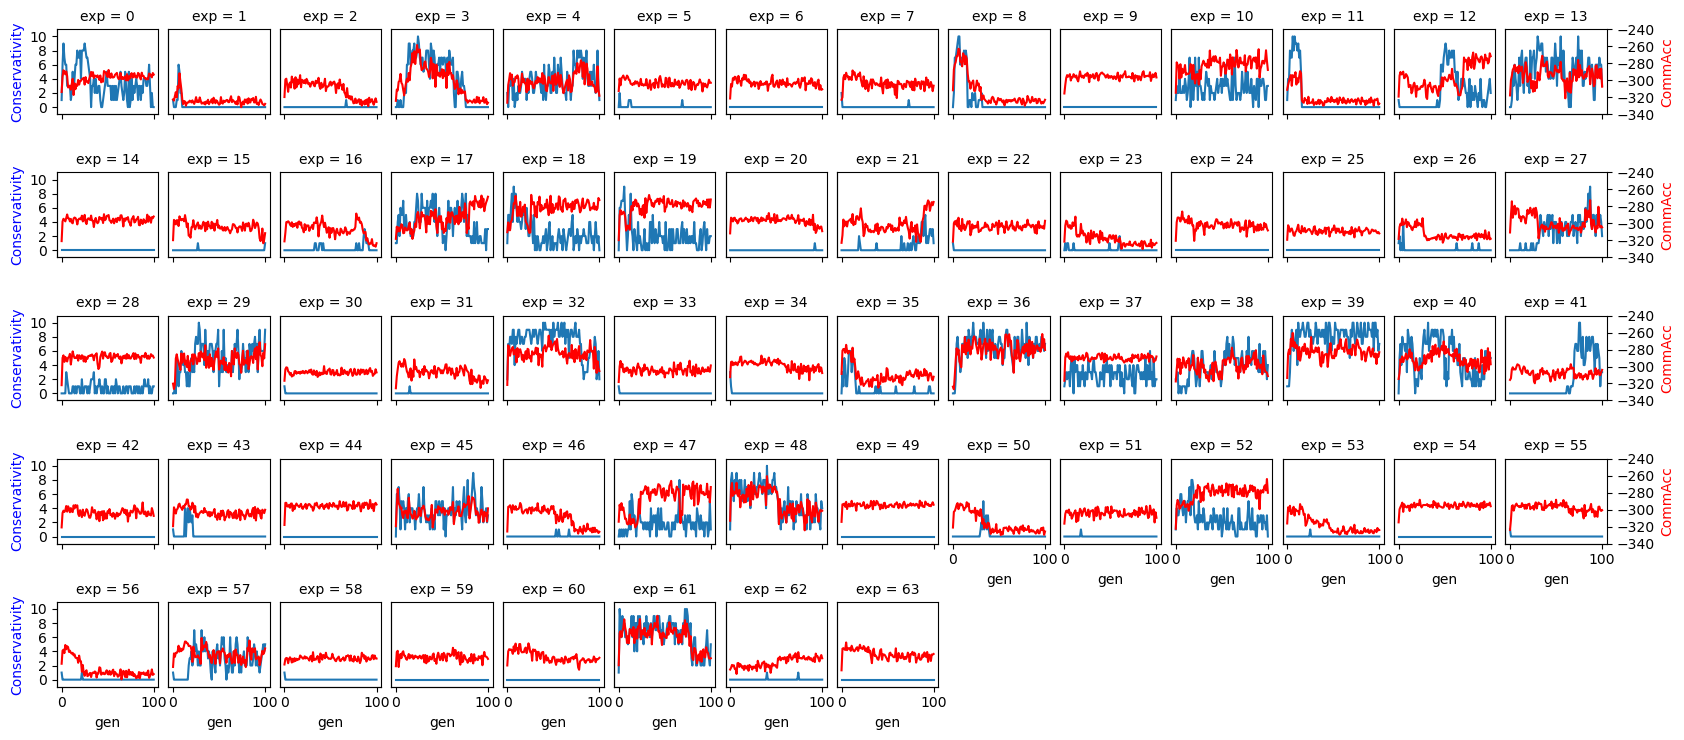

In [15]:
col_wrap = 14

g = sns.FacetGrid(
    reshuffled_data.groupby(['gen','exp']).agg({'commAcc': 'mean', 'conservative': 'sum'}).reset_index(),
    col='exp',
    col_wrap=col_wrap,
    sharey=False,
    height=1.5,
    aspect=0.8
)

# Custom function to plot on primary and secondary axes
def plot_lines(data, **kwargs):
    # Plot the 'conservative' line on the primary axis
    ax = sns.lineplot(data=data, x='gen', y='conservative', **kwargs)
    
    # Set the labels for the primary and secondary y-axes
    ax.set_ylabel('Conservative', color='b')

    # Create or reuse the secondary y-axis for 'commAcc'
    if not hasattr(ax, 'right_ax'):
        ax.right_ax = ax.twinx()

        kwargs['color'] = 'red'
        # Plot the 'commAcc' line on the secondary axis
        sns.lineplot(data=data, x='gen', y='commAcc', ax=ax.right_ax, **kwargs)
        # Initially, set the CommAcc ylabel to be empty
        ax.right_ax.set_ylabel('')
        ax.set_ylabel('')

    # Set the legend for the lines
    # ax.figure.legend()

# Map the dataframe to the custom plotting function
g.map_dataframe(plot_lines)

# Adjust the layout

# Iterate over each subplot (facet)
for ax in g.axes.flat:
    ax.right_ax.set_ylim(-340,-240)
    ax.right_ax.set_yticks([])
    ax.set_ylim(-1,11)
    ax.set_yticks([])
    
i = 1
for ax in g.axes.flat:
    if i % col_wrap == 0:
        # If it is, set the ylabel for the secondary y-axis
        ax.right_ax.set_ylabel('CommAcc',color='red')
        ax.right_ax.set_yticks(np.arange(-340,-230, 20))
    i += 1

i = 0
for ax in g.axes.flat:
    if i % col_wrap == 0:
        print(i)
        # If it is, set the ylabel for the y-axis
        ax.set_yticks(np.arange(0,11,2))
        ax.set_ylabel('Conservativity')
    i += 1

g.fig.subplots_adjust(wspace=0.1)
    
# Show the plot
g.fig.savefig('./gens.png', dpi=300)

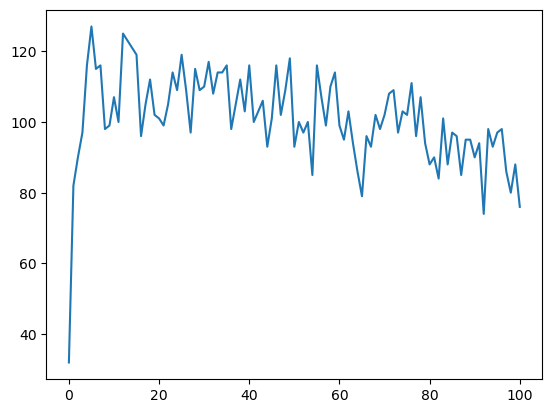

In [16]:
plt.plot(reshuffled_data.groupby(['gen']).conservative.sum())

### Explore individual generations

In [151]:
df_plot = reshuffled_data[reshuffled_data['exp']==2]

(-2.0, 60.0)

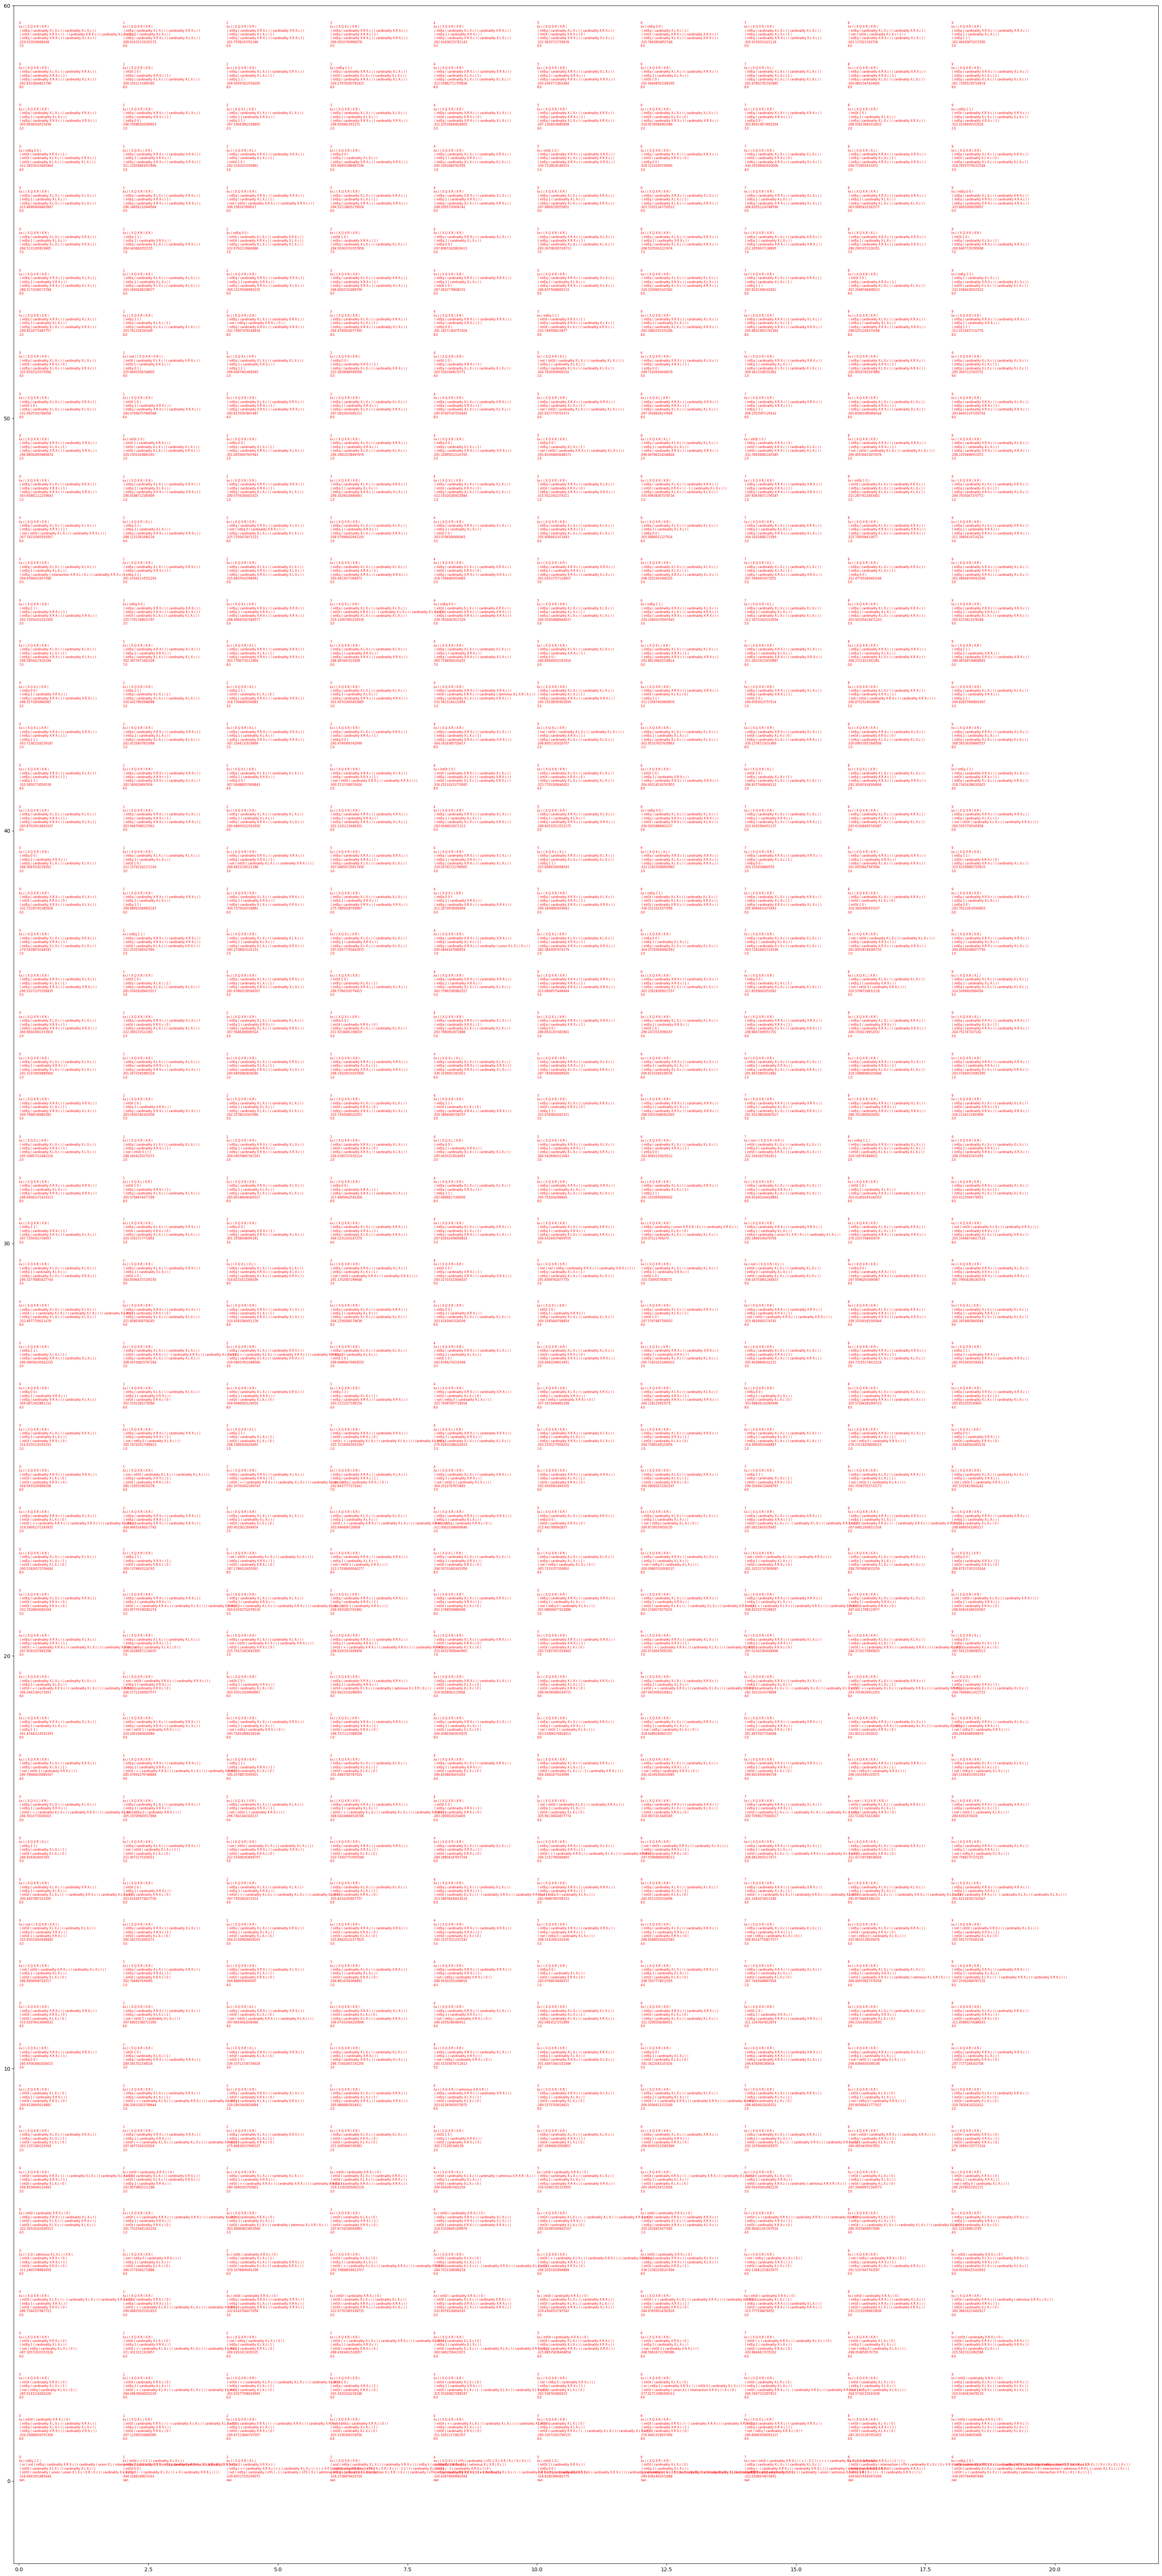

In [152]:
fig,ax = plt.subplots(figsize=(40,90))
for i, agent in df_plot.iterrows():
    color = 'blue' if agent.conservative else 'red'
    text = (
        str(agent.child)
        + '\n'
        + agent.comp
        +'\n'
        +str(agent.Q1)
        + '\n'
        +str(agent.Q2)
        + '\n'
        +str(agent.Q3)
        + '\n'
        +str(agent.commAcc)
        +'\n'+str(agent.parent)
    )
    ax.text(
        agent.child*2, 
        agent.gen, 
        text,
        color=color,
        fontsize='xx-small'
    )
ax.set_xlim(-0.1,22)
ax.set_ylim(-2,df_plot.gen.max()+1)

In [58]:
pprint(data[4]['generation'][3]['children'][4]['hypothesis'].split('|'))

['λx.( ( X.Q ( intersection X.L X.R ) ) X.R ) ',
 ' ( intGt 1 ( cardinality X.L X.c ) ) ',
 ' ( intEq ( cardinality X.L X.c ) ( cardinality X.L X.c ) ) ',
 ' ( intEq ( cardinality X.R X.c ) 1 )']


In [56]:
data[4]['generation'][4]['children'][1]['learningData']

['[DATA: { (-4, 0), (1, 1), (7, 1), (8, 0), (10, 0),  } -> ( ( Q1 target ) even ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-9, 0), (0, 0), (5, 1), (9, 0), (10, 1),  } -> ( something 0 ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-8, 0), (2, 0), (4, 0), (6, 1), (8, 1),  } -> ( ( Q1 target ) prime ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-10, 1), (-7, 0), (-6, 1), (-4, 1), (-1, 0),  } -> ( ( Q1 even ) distractor ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-5, 1), (1, 0), (2, 0), (3, 0), (8, 0),  } -> ( ( Q3 0 ) target ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-6, 0), (-2, 0), (1, 1), (3, 1), (9, 0),  } -> ( l_not ( ( Q3 distractor ) 5 ) ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-9, 0), (-8, 1), (-7, 0), (1, 0), (5, 0),  } -> ( ( Q3 prime ) target ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-8, 1), (-5, 0), (1, 0), (4, 0), (7, 1),  } -> ( ( Q3 9 ) 1 ) w/ reliability 0.9999 and count 1]',
 '[DATA: { (-10, 1), (-9, 0), (4, 1), (5, 0), 

### Uniques by generation

In [191]:
def calculate_unique(x, prop):
    y, counts = np.unique(x[prop],return_counts=True)
    args = np.argsort(counts)[::-1][:10]
    sorted_counts = counts[args]
    print(sorted_counts)
    sorted_values = y[args]
    return pd.Series(sorted_values)

In [193]:
reshuffled_data.columns

Index(['exp', 'gen', 'child', 'hyp', 'commAcc', 'parent', 'original', 'comp',
       'Q1', 'Q2', 'Q3', 'conservative'],
      dtype='object')

In [197]:
df = reshuffled_data.groupby(['gen','exp']).apply(calculate_unique, 'comp').reset_index()

[2 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 2 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 2 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 2 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[3 2 2 1 1 1]
[2 1 1 1 1 1 1 1 1]
[2 2 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 2 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 2 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[2 2 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[2 2 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 2 1 1 1 1 1]
[3 2 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[3 1 1 1 1 1 1 1]
[2 1 1 1 1 1 1 1 1]
[2 1 1 1 1 1

In [198]:
df

,gen,exp,level_2,0
0,0,0,0,λx.( ( X.Q X.L ) X.L )
1,0,0,1,λx.( not ( intGt 1 ( cardinality X.R X.c ) ) )
2,0,0,2,λx.( intGt 1 ( cardinality X.R X.c ) )
3,0,0,3,λx.( intGt 0 0 )
4,0,0,4,λx.( intGt ( - 1 1 ) ( cardinality X.L X.c ) )
...,...,...,...,...
18514,100,28,1,λx.( ( X.Q ( setminus X.R X.L ) ) X.R )
18515,100,30,0,λx.( intGt ( cardinality X.L X.c ) 1 )
18516,100,30,1,λx.( ( X.Q X.L ) X.L )
18517,100,44,0,λx.( intEq 1 ( cardinality X.L X.c ) )


In [ ]:
pd.DataFrame.to_latex(

In [208]:
print(
    df[(df['exp']==32)].drop(columns='exp').pivot(index='gen', columns=['level_2'])
    .to_latex(na_rep='')
    .replace('λx.','')
    .replace('X.', '')
)

\begin{tabular}{lllllllllll}
\toprule
 & \multicolumn{10}{r}{0} \\
level_2 & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
gen &  &  &  &  &  &  &  &  &  &  \\
\midrule
0 & ( ( Q L ) R )  & ( intGt ( cardinality L c ) ( + 0 ( cardinality ( setminus L R ) c ) ) )  & ( intEq 1 ( - 0 ( cardinality R c ) ) )  & ( intEq 0 ( + ( cardinality R c ) 1 ) )  & ( intEq 0 ( + ( cardinality L c ) 1 ) )  & ( intEq ( - ( cardinality ( nTh ( cardinality R c ) c L ) c ) 0 ) 0 )  & ( ( Q R ) R )  & ( ( Q L ) ( intersection R L ) )  & ( ( Q ( nTh 0 c R ) ) L )  &  \\
1 & ( ( Q ( intersection R L ) ) L )  & ( ( Q L ) R )  & ( not ( ( Q R ) L ) )  & ( ( Q L ) ( setminus L R ) )  & ( ( Q L ) ( intersection R L ) )  & ( ( Q ( setminus L R ) ) L )  & ( ( Q ( intersection L R ) ) L )  &  &  &  \\
2 & ( ( Q L ) R )  & ( ( Q ( intersection R L ) ) L )  & ( ( Q L ) ( setminus L R ) )  & ( ( Q L ) ( intersection L R ) )  & ( ( Q ( intersection L ( intersection L R ) ) ) L )  &  &  &  &  &  \\
3 & ( not ( ( Q R ) L ) )  

## Only learning

In [11]:
only_learning_data = get_data('../../data/only_learning/')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [12]:
print('proportion conservative: ', only_learning_data.conservative.mean())

proportion conservative:  0.0060643564356435645


In [13]:
only_learning_data

,exp,gen,child,hyp,commAcc,parent,original,comp,Q1,Q2,Q3,conservative
0,0,0,0,λx.( ( X.Q X.R ) X.L ) | ( intEq 1 ( + ( cardi...,-327.175131,NaN,None,λx.( ( X.Q X.R ) X.L ),( intEq 1 ( + ( cardinality X.L X.c ) ( cardi...,( not ( intEq ( cardinality X.R X.c ) ( + ( +...,( or ( intGt ( cardinality X.L X.c ) ( cardin...,False
1,0,0,1,λx.( ( X.Q ( union X.R X.L ) ) X.R ) | ( intEq...,-321.552300,NaN,None,λx.( ( X.Q ( union X.R X.L ) ) X.R ),( intEq 1 1 ),( intGt ( cardinality ( setminus X.R X.R ) X....,( intEq ( - ( - ( cardinality X.L X.c ) ( + (...,True
2,0,0,2,λx.( ( X.Q ( union X.R X.R ) ) X.L ) | ( intGt...,-326.357670,NaN,None,λx.( ( X.Q ( union X.R X.R ) ) X.L ),( intGt ( cardinality X.R X.c ) ( cardinality...,( intGt ( cardinality X.R X.c ) ( - 1 ( cardi...,( intEq ( cardinality X.R X.c ) 0 ),False
3,0,0,3,λx.( intGt ( cardinality X.R X.c ) 0 ) | ( int...,-322.320212,NaN,None,λx.( intGt ( cardinality X.R X.c ) 0 ),( intEq ( cardinality X.L X.c ) 0 ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...,False
4,0,0,4,λx.( intGt ( + 1 ( cardinality X.R X.c ) ) 0 )...,-311.727821,NaN,None,λx.( intGt ( + 1 ( cardinality X.R X.c ) ) 0 ),( intGt ( cardinality X.L X.c ) ( + ( + 1 ( c...,( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( - ( + 1 1 ) ( cardinality X.L X.c )...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
16155,15,100,5,λx.( intGt 1 0 ) | ( intGt ( cardinality X.L X...,-325.630843,3.0,None,λx.( intGt 1 0 ),( intGt ( cardinality X.L X.c ) ( cardinality...,( intEq 1 ( cardinality X.L X.c ) ),( intGt ( cardinality X.L X.c ) ( cardinality...,False
16156,15,100,6,λx.( intEq 0 0 ) | ( intGt ( cardinality X.L X...,-336.280999,9.0,None,λx.( intEq 0 0 ),( intGt ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,False
16157,15,100,7,λx.( ( X.Q X.R ) X.R ) | ( intEq ( cardinality...,-329.150706,4.0,None,λx.( ( X.Q X.R ) X.R ),( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq 1 1 ),( intEq ( cardinality X.R X.c ) ( cardinality...,False
16158,15,100,8,λx.( ( X.Q X.L ) X.R ) | ( intEq ( cardinality...,-308.520239,4.0,None,λx.( ( X.Q X.L ) X.R ),( intEq ( cardinality X.R X.c ) ( cardinality...,( intEq ( cardinality X.L X.c ) ( cardinality...,( intEq ( cardinality X.R X.c ) ( cardinality...,False


## Compare only learning with learning+communication

In [163]:
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import bootstrap

In [ ]:
# min_learning, max_learning = proportion_confint(
#     only_learning_data.conservative.sum(), 
#     only_learning_data.conservative.size, 
#     alpha=0.05, 
#     method='normal', 
# )

# min_learning_comm, max_learning_comm = proportion_confint(
#     reshuffled_data.conservative.sum(), 
#     reshuffled_data.conservative.size, 
#     alpha=0.05,
#     method='normal',
# )

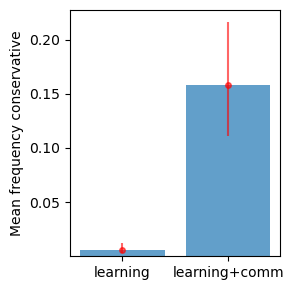

In [184]:
fig, ax = plt.subplots(figsize=(3,3))

ax.bar(
    [0,1],
    [only_learning_data.conservative.mean(),
     reshuffled_data.conservative.mean()],
    alpha=0.7
)

mean_learning, mean_learning_comm = only_learning_data.conservative.mean(), reshuffled_data.conservative.mean()
min_learning, max_learning = bootstrap(
    (only_learning_data.groupby('exp').conservative.mean(),), 
    np.mean
).confidence_interval
min_learning_comm, max_learning_comm = bootstrap(
    (reshuffled_data.groupby('exp').conservative.mean(),), 
    np.mean
).confidence_interval

yerr = np.array([
    [mean_learning-min_learning, mean_learning_comm-min_learning_comm],
    [max_learning-mean_learning, max_learning_comm-mean_learning_comm]
])

ax.errorbar(
    [0,1],
    [mean_learning, mean_learning_comm],
    yerr=yerr,
    fmt='o',
    color="red",
    alpha=0.6,
    markersize=4
)

ax.set_yticks([0.05, 0.1, 0.15, 0.2])
ax.set_ylabel('Mean frequency conservative')

ax.set_xticks([0,1])
ax.set_xticklabels(['learning', 'learning+comm'])
fig.tight_layout()

fig.savefig('comparisonFrequency.png', dpi=300)

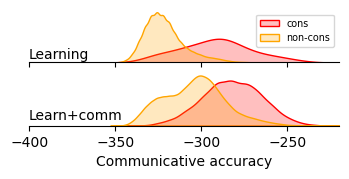

In [183]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4,2), sharex=True)

sns.kdeplot(
    only_learning_data.commAcc[only_learning_data.conservative].values, 
    color='red',
    label='cons',
    ax=ax1,
    fill=True
)

sns.kdeplot(
    only_learning_data.commAcc[np.logical_not(only_learning_data.conservative)].values,
    label='non-cons',
    color='orange',
    ax=ax1,
    fill=True
)

ax1.legend(fontsize='x-small')

sns.kdeplot(
    reshuffled_data.commAcc[reshuffled_data.conservative].values, 
    color='red',
    label='cons learning+comm',
    ax=ax2,
    fill=True
)

sns.kdeplot(
    reshuffled_data.commAcc[np.logical_not(reshuffled_data.conservative)].values,
    label='non-cons learning+comm',
    color='orange',
    ax=ax2,
    fill=True
)

sns.despine(ax=ax1, left=True)
sns.despine(ax=ax2, left=True)
for ax in [ax1,ax2]:
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.patch.set_alpha(0.0)

plt.subplots_adjust(bottom=0.3)
ax1.set_xlim(-400, -220)
ax1.text(-400, 0.003, 'Learning')
ax2.text(-400, 0.003, 'Learn+comm')
ax.set_xlabel('Communicative accuracy')
fig.savefig('CommAccOnlyLearning.png', dpi=300)

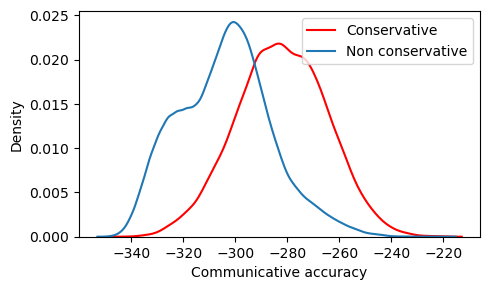

In [13]:
fig, ax = plt.subplots(figsize=(5,3))
sns.kdeplot(
    reshuffled_data.commAcc[reshuffled_data.conservative].values, 
    color='red',
    label='Conservative',
    ax=ax
)

sns.kdeplot(
    reshuffled_data.commAcc[np.logical_not(reshuffled_data.conservative)].values,
    label='Non conservative',
    ax=ax
)
ax.legend()
ax.set_xlabel('Communicative accuracy')
fig.tight_layout()
fig.savefig('CommAcc.png', dpi=300)